In [3]:
# Standard library imports
import os
import re
import zipfile

# Third-party imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive

In [2]:
# Make sure Google Drive is mounted
drive.mount('/content/drive', force_remount=True)

# Path to your zip file
zip_path = '/content/drive/MyDrive/silhouette/archive.zip'

Mounted at /content/drive


# Explore Zip Structure Function

In [ ]:
def explore_zip_structure(zip_path):
    print(f"Exploring zip file: {zip_path}")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Print the number of files
            file_list = zip_ref.namelist()

            # Look for PNG files
            png_files = [f for f in file_list if f.endswith('.png')]
            print(f"\nTotal PNG files: {len(png_files)}")

            if png_files:
                print("\nSample PNG paths:")
                for file_path in png_files[:5]:
                    print(f"  {file_path}")

                # Check directory structure of first PNG
                print("\nExample directory structure:")
                path_parts = png_files[0].split('/')
                print(f"Path parts: {path_parts}")

                # Try to find the expected pattern with corrected interpretation
                pattern_found = False
                for file_path in png_files:
                    parts = file_path.split('/')
                    if len(parts) >= 5 and parts[0] == 'output':
                        pattern_found = True
                        print(f"\nFound valid pattern in: {file_path}")
                        print(f"Subject: {parts[1]}")  # Changed from parts[-5]
                        print(f"Condition: {parts[2]}")  # Changed from parts[-4]
                        print(f"Angle: {parts[3]}")  # Changed from parts[-3]
                        print(f"Image filename: {parts[4]}")  # Added to show the actual image filename
                        break

                if not pattern_found:
                    print("\nCould not find expected directory pattern in PNG files")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file.")
    except FileNotFoundError:
        print(f"Error: The file {zip_path} was not found.")
    except Exception as e:
        print(f"Error: {str(e)}")

In [ ]:
explore_zip_structure(zip_path)

Exploring zip file: /content/drive/MyDrive/silhouette/archive.zip

Total PNG files: 1128626

Sample PNG paths:
  output/001/bg-01/000/001-bg-01-000-001.png
  output/001/bg-01/000/001-bg-01-000-002.png
  output/001/bg-01/000/001-bg-01-000-003.png
  output/001/bg-01/000/001-bg-01-000-004.png
  output/001/bg-01/000/001-bg-01-000-005.png

Example directory structure:
Path parts: ['output', '001', 'bg-01', '000', '001-bg-01-000-001.png']

Found valid pattern in: output/001/bg-01/000/001-bg-01-000-001.png
Subject: 001
Condition: bg-01
Angle: 000
Image filename: 001-bg-01-000-001.png


# Dataset Class Definition

In [ ]:
class SilhouetteSequenceDataset(Dataset):
    def __init__(self, zip_path, transform=None, mode='train', val_size=0.15, test_size=0.15, seed=42, seq_length=16):
        """
        Dataset for silhouette recognition that maintains all classes in all splits

        Args:
            zip_path: Path to the zip file containing the images
            transform: Image transformations to apply
            mode: One of 'train', 'val', or 'test'
            val_size: Proportion of data to use for validation (from non-test data)
            test_size: Proportion of data to use for testing
            seed: Random seed for reproducibility
            seq_length: Number of frames in each sequence
        """
        self.zip_path = zip_path
        self.transform = transform
        self.mode = mode
        self.seq_length = seq_length
        self.samples = []
        self.zip_handle = None

        print(f"Initializing dataset with mode: {mode}")

        # Get file list from the zip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            all_files = zip_ref.namelist()

        # Filter to only include .png files
        image_files = [f for f in all_files if f.endswith('.png')]

        # Group files by subject, scenario, and angle
        sequences = {}
        for file_path in image_files:
            parts = file_path.split('/')

            if len(parts) >= 5 and parts[0] == 'output':
                subject = parts[1]      # '001'
                scenario = parts[2]     # 'bg-01'
                angle = parts[3]        # '000'

                key = (subject, scenario, angle)
                if key not in sequences:
                    sequences[key] = []
                sequences[key].append(file_path)

        print(f"Found {len(sequences)} sequences across all subjects")

        # Sort sequences by frame number with error handling
        def extract_frame_number(filepath):
            try:
                # Extract the last number before .png
                match = re.search(r'-(\d+)\.png$', filepath)
                if match:
                    return int(match.group(1))
                return 0  # Default value if no match found
            except (AttributeError, ValueError):
                return 0  # Default value if parsing fails

        # Sort sequences by frame number
        for key in sequences:
            sequences[key].sort(key=extract_frame_number)

        # Group sequences by subject
        subject_sequences = {}
        for key, files in sequences.items():
            subject, scenario, angle = key
            if subject not in subject_sequences:
                subject_sequences[subject] = []
            subject_sequences[subject].append((scenario, angle, files))

        # For each subject, split their sequences between train, val and test
        for subject, subject_data in subject_sequences.items():
            # Convert subject ID to 0-based label
            label = int(subject) - 1

            # Get unique scenarios for this subject
            scenarios = list(set(sd[0] for sd in subject_data))

            # Do a proper three-way split
            # First split off the test set
            remaining_scenarios, test_scenarios = train_test_split(
                scenarios, test_size=test_size, random_state=seed
            )

            # Then split the remaining into train and validation
            train_scenarios, val_scenarios = train_test_split(
                remaining_scenarios, test_size=val_size/(1-test_size), random_state=seed
            )

            # Select scenarios based on mode
            if mode == 'train':
                selected_scenarios = train_scenarios
            elif mode == 'val':
                selected_scenarios = val_scenarios
            elif mode == 'test':
                selected_scenarios = test_scenarios

            # Process sequences for selected scenarios
            for scenario, angle, files in subject_data:
                if scenario in selected_scenarios:
                    if len(files) >= self.seq_length:
                        # Create sequences with stride
                        for i in range(0, max(1, len(files) - self.seq_length + 1), 8):
                            if i + self.seq_length <= len(files):
                                self.samples.append((files[i:i+self.seq_length], label))
                    else:
                        # Pad shorter sequences
                        padded_sequence = files + [files[-1]] * (self.seq_length - len(files))
                        self.samples.append((padded_sequence[:self.seq_length], label))

        print(f"Created {len(self.samples)} sequence samples for {mode}")
        print(f"Number of unique subjects in {mode}: {len(set(label for _, label in self.samples))}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.zip_handle is None:
            self.zip_handle = zipfile.ZipFile(self.zip_path, 'r')

        file_paths, label = self.samples[idx]
        sequence = []

        # Extract and process each image in the sequence
        for file_path in file_paths:
            with self.zip_handle.open(file_path) as file:
                image = Image.open(file).convert('L')  # Convert to grayscale
                if self.transform:
                    image = self.transform(image)
                sequence.append(image)

        # Stack the sequence into a tensor
        sequence_tensor = torch.stack(sequence)
        return sequence_tensor, label

    def __del__(self):
        if self.zip_handle is not None:
            self.zip_handle.close()

# Define Transforms and Create Datasets

In [ ]:
# Define transforms with moderate augmentation
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomErasing(p=0.2)
])

transform_val_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets with separate transforms
train_dataset = SilhouetteSequenceDataset(
    zip_path,
    transform=transform_train,
    mode='train',
    val_size=0.15,    # 15% for validation
    test_size=0.15,   # 15% for test
    seq_length=16
)

val_dataset = SilhouetteSequenceDataset(
    zip_path,
    transform=transform_val_test,
    mode='val',
    val_size=0.15,
    test_size=0.15,
    seq_length=16
)

test_dataset = SilhouetteSequenceDataset(
    zip_path,
    transform=transform_val_test,
    mode='test',
    val_size=0.15,
    test_size=0.15,
    seq_length=16
)

Initializing dataset with mode: train
Found 13702 sequences across all subjects
Created 73105 sequence samples for train
Number of unique subjects in train: 125
Initializing dataset with mode: val
Found 13702 sequences across all subjects
Created 24154 sequence samples for val
Number of unique subjects in val: 125
Initializing dataset with mode: test
Found 13702 sequences across all subjects
Created 24195 sequence samples for test
Number of unique subjects in test: 125


# Create Data Loaders

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

# Print dataset statistics
print(f"Training sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")
print(f"Testing sequences: {len(test_dataset)}")

Training sequences: 73105
Validation sequences: 24154
Testing sequences: 24195


# Model Definition - CSTL (CNN-Spatiotemporal Learning)

In [4]:
class CSTL(nn.Module):
    def __init__(self, num_classes=125, cnn_channels=[32, 64, 128, 256], mste_scales=[1, 2, 4, 8],
                 attention_heads=8, dropout=0.3):
        super(CSTL, self).__init__()
        #raw data= [16,16,64,64]
        # CNN Backbone
        #input [265,1,64,64]
        self.cnn_backbone = nn.Sequential(
            # First block
            nn.Conv2d(1, cnn_channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[0], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout),
            #output [256,32,32,32]

            # Second block
            nn.Conv2d(cnn_channels[0], cnn_channels[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[1], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout),
            #output [256,64,8,8]

            # Third block
            nn.Conv2d(cnn_channels[1], cnn_channels[2], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[2], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout),
            #output [256,128,4,4]

            # Fourth block
            nn.Conv2d(cnn_channels[2], cnn_channels[3], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[3], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )#output [256,256,1,1]


        # Multi-Scale Temporal Encoding (MSTE)
        #input [16,256,16]
        self.mste = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(cnn_channels[3], cnn_channels[3] // 2, kernel_size=scale, stride=scale),
                nn.BatchNorm1d(cnn_channels[3] // 2, momentum=0.1),
                nn.ReLU(inplace=True)
            ) for scale in mste_scales
        ])
        #output [16,30,128]

        # Adaptive Temporal Attention (ATA)
        self.attention = nn.MultiheadAttention(
            embed_dim=cnn_channels[3] // 2,
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )
        #output= [16,30,128]

        # Classification head
        #input= [16,128]
        self.classifier = nn.Sequential(
            nn.Linear(cnn_channels[3] // 2, 512),
            #output= [16,512]
            nn.BatchNorm1d(512, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        #output= [16,125]

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)

        # Reshape for CNN processing
        x = x.view(-1, 1, 64, 64)  # [batch_size * seq_len, 1, 64, 64]=[256,1,64,64]

        # CNN backbone
        x = self.cnn_backbone(x)  # [batch_size * seq_le, channels, 1, 1]=[256,256,1,1]
        x = x.view(batch_size, seq_len, -1)  # [batch_size, seq_len, channels]=[16,16,256]

        # Multi-Scale Temporal Encoding
        mste_outputs = []
        for mste_layer in self.mste:
            # Process each temporal scale
            scale_output = mste_layer(x.transpose(1, 2))  # [batch_size, channels, seq_len]=[16,256,16]
            mste_outputs.append(scale_output.transpose(1, 2))  # [batch_size, seq_len, channels] ->output=[16,16,128],[16,8,128],[16,4,128],[16,2,128]

        # Concatenate multi-scale features
        x = torch.cat(mste_outputs, dim=1)  # [batch_size, seq_len * num_scales, channels]=[16,30,128]

        # Adaptive Temporal Attention
        attn_output, _ = self.attention(x, x, x)  # [batch_size, seq_len * num_scales, channels]=[16,30,128]

        # Global temporal pooling
        x = attn_output.mean(dim=1)  # [batch_size, channels]=[16,128]

        # Classification
        x = self.classifier(x)  # [batch_size, num_classes]

        return x

# Model Initialization and Checkpoint Management

In [ ]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSTL(num_classes=125).to(device)

# Create save directory if it doesn't exist
save_dir = '/content/drive/MyDrive/silhouette'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def find_latest_checkpoint():
    """Find the latest checkpoint in the save directory"""
    checkpoints = []

    # Check for epoch checkpoints and batch checkpoints
    for f in os.listdir(save_dir):
        if f.startswith('cstl_checkpoint_epoch_') and f.endswith('.pth'):
            try:
                # Extract epoch and batch numbers
                parts = f.split('_')
                epoch_num = int(parts[3])
                if len(parts) > 4:  # Has batch number
                    batch_num = int(parts[5].split('.')[0])
                    checkpoints.append(('batch', epoch_num, batch_num, f))
                else:
                    checkpoints.append(('epoch', epoch_num, 0, f))
            except:
                continue
        elif f.startswith('cstl_model_epoch_') and f.endswith('.pth'):
            try:
                epoch_num = int(f.split('_')[3].split('.')[0])
                checkpoints.append(('epoch', epoch_num, 0, f))
            except:
                continue

    if not checkpoints:
        return None

    # Sort by epoch number and then batch number
    checkpoints.sort(key=lambda x: (x[1], x[2]), reverse=True)
    #lamda receives each element from checkpoints as x during sorting
    return checkpoints[0]  # Returns tuple of (type, epoch_num, batch_num, filename)

# Load Checkpoint

In [ ]:
# Try to find the latest checkpoint
latest_checkpoint = find_latest_checkpoint()
start_epoch = 1

# Initialize criterion with reduced label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# Initialize optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0001,
    weight_decay=0.03,
    betas=(0.9, 0.999)
)

# Initialize scheduler
total_steps = len(train_loader) * (20 - start_epoch + 1)
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.0004,
    total_steps=total_steps,
    pct_start=0.15,
    div_factor=10,
    final_div_factor=100,
    anneal_strategy='cos'
)

if latest_checkpoint:
    checkpoint_type, epoch_num, batch_num, filename = latest_checkpoint
    checkpoint_path = os.path.join(save_dir, filename)
    print(f"Found {checkpoint_type} checkpoint from epoch {epoch_num}" +
          (f" batch {batch_num}" if checkpoint_type == 'batch' else "") +
          f": {filename}")

    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        start_epoch = epoch_num + (1 if checkpoint_type == 'epoch' else 0)
        print(f"Successfully loaded checkpoint. Resuming from epoch {start_epoch}")

        # Load optimizer and scheduler states if available
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Update total_steps in case of resuming training
        scheduler.total_steps = len(train_loader) * (20 - start_epoch + 1)

    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        print("Starting training from scratch")
        start_epoch = 1
        # Recompute total_steps for fresh training
        scheduler.total_steps = len(train_loader) * 20
else:
    print("No checkpoint found. Starting training from scratch")

Found epoch checkpoint from epoch 10: cstl_model_epoch_10.pth
Successfully loaded checkpoint. Resuming from epoch 11


# Training Function Definition

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler,
                start_epoch=1, num_epochs=20, patience=12):
    print("Entering train_model function")
    device = next(model.parameters()).device
    # Gets device (CPU/GPU)
    best_acc = 0
    patience_counter = 0
    grad_accumulation_steps = 3

    save_dir = '/content/drive/MyDrive/silhouette'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    print("Starting training with the following configuration:")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Batch size: {train_loader.batch_size} (effective: {train_loader.batch_size * grad_accumulation_steps})")
    print(f"Initial learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"Device: {device}")
    print(f"Starting from epoch: {start_epoch}")
    print(f"Save directory: {save_dir}")
    print(f"Early stopping patience: {patience} epochs")

    # Verify Google Drive is mounted
    if not os.path.exists('/content/drive'):
        raise RuntimeError("Google Drive is not mounted! Please mount it before training.")

    print("Initializing GradScaler...")
    scaler = torch.amp.GradScaler()

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\nStarting Epoch {epoch}/{num_epochs}")
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        optimizer.zero_grad()  # Zero gradients at start of epoch
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}')
        #initializes progress bar.

        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels) / grad_accumulation_steps

            scaler.scale(loss).backward()

            if (batch_idx + 1) % grad_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

            running_loss += loss.item() * grad_accumulation_steps
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item() * grad_accumulation_steps:.4f}',
                'acc': f'{100.0 * correct / total:.2f}%',
                'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })

            # Save batch checkpoints every 2000 batches
            if (batch_idx + 1) % 2000 == 0:
                checkpoint_path = os.path.join(save_dir, f'cstl_checkpoint_epoch_{epoch}_batch_{batch_idx+1}.pth')
                torch.save({
                    'epoch': epoch,
                    'batch_idx': batch_idx,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': loss.item(),
                }, checkpoint_path)
                print(f"\nBatch checkpoint saved to {checkpoint_path}")

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total

        # Validation phase
        model.eval()
        val_acc, _, _ = evaluate_model(model, val_loader)

        print(f'Epoch {epoch} Summary - Loss: {epoch_loss:.4f}, '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Save epoch checkpoint at the end of each epoch
        epoch_path = os.path.join(save_dir, f'cstl_model_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': epoch_loss,
            'val_acc': val_acc,
        }, epoch_path)
        print(f"Epoch {epoch} checkpoint saved to {epoch_path}")

        # Early stopping logic with best model saving
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0  # Reset patience counter when we find a better model
            print(f"New best validation accuracy: {best_acc:.2f}%")
            best_path = os.path.join(save_dir, f'cstl_best_model_epoch_{epoch}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': epoch_loss,
                'val_acc': val_acc,
            }, best_path)
            print(f"Best model saved to {best_path}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter}/{patience} epochs. Best val acc: {best_acc:.2f}%")

            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch} epochs")
                break

    print(f"Training completed. Best validation accuracy: {best_acc:.2f}%")

    # Load the best model for final evaluation
    best_model_path = os.path.join(save_dir, f'cstl_best_model_epoch_{epoch-patience_counter}.pth')
    if os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path} for final evaluation")
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])

    return model

# Evaluation function definition

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Save predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100.0 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy, all_predictions, all_labels

# Model Saving Function

In [ ]:
def save_model(model, filename):
    save_path = os.path.join('/content/drive/MyDrive/silhouette', filename)
    torch.save({
        'model_state_dict': model.state_dict(),
    }, save_path)
    print(f"Model saved to {save_path}")

# Run Training and Evaluation

In [ ]:
# Train the model
print(f"Starting training on device: {device}")
# When calling the train function, pass val_loader explicitly
model = train_model(
    model,
    train_loader,
    val_loader,       # Pass validation loader here
    test_loader,
    criterion,
    optimizer,
    scheduler,
    start_epoch=start_epoch,
    num_epochs=20,
    patience=12       # Specify patience explicitly
)

# Evaluate final model
accuracy, predictions, true_labels = evaluate_model(model, test_loader)

# Save final model
save_model(model, 'cstl_final_model.pth')

Starting training on device: cuda
Entering train_model function
Starting training with the following configuration:
Number of training batches: 4570
Batch size: 16 (effective: 48)
Initial learning rate: 0.000040
Device: cuda:0
Starting from epoch: 11
Save directory: /content/drive/MyDrive/silhouette
Early stopping patience: 12 epochs
Initializing GradScaler...

Starting Epoch 11/20


Epoch 11/20:  44%|████▍     | 2000/4570 [08:15<11:47,  3.63it/s, loss=1.6982, acc=72.05%, lr=0.000399]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_11_batch_2000.pth


Epoch 11/20:  88%|████████▊ | 4001/4570 [16:04<01:49,  5.18it/s, loss=1.2991, acc=72.74%, lr=0.000398]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_11_batch_4000.pth


Epoch 11/20: 100%|██████████| 4570/4570 [18:15<00:00,  4.17it/s, loss=5.3982, acc=72.96%, lr=0.000398]


Test Accuracy: 85.20%
Epoch 11 Summary - Loss: 1.4288, Train Acc: 72.96%, Val Acc: 85.20%
Epoch 11 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_11.pth
New best validation accuracy: 85.20%
Best model saved to /content/drive/MyDrive/silhouette/cstl_best_model_epoch_11.pth

Starting Epoch 12/20


Epoch 12/20:  44%|████▍     | 2000/4570 [07:58<10:41,  4.00it/s, loss=0.8695, acc=75.44%, lr=0.000397]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_12_batch_2000.pth


Epoch 12/20:  88%|████████▊ | 4000/4570 [15:51<03:18,  2.86it/s, loss=1.3976, acc=76.14%, lr=0.000396]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_12_batch_4000.pth


Epoch 12/20: 100%|██████████| 4570/4570 [18:04<00:00,  4.21it/s, loss=6.5760, acc=76.14%, lr=0.000396]


Test Accuracy: 89.06%
Epoch 12 Summary - Loss: 1.3340, Train Acc: 76.14%, Val Acc: 89.06%
Epoch 12 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_12.pth
New best validation accuracy: 89.06%
Best model saved to /content/drive/MyDrive/silhouette/cstl_best_model_epoch_12.pth

Starting Epoch 13/20


Epoch 13/20:  44%|████▍     | 2000/4570 [07:45<09:22,  4.57it/s, loss=1.4669, acc=77.91%, lr=0.000394]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_13_batch_2000.pth


Epoch 13/20:  88%|████████▊ | 4000/4570 [15:41<02:32,  3.73it/s, loss=0.9200, acc=78.52%, lr=0.000393]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_13_batch_4000.pth


Epoch 13/20: 100%|██████████| 4570/4570 [17:53<00:00,  4.26it/s, loss=2.4178, acc=78.57%, lr=0.000393]


Test Accuracy: 87.17%
Epoch 13 Summary - Loss: 1.2583, Train Acc: 78.57%, Val Acc: 87.17%
Epoch 13 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_13.pth
No improvement for 1/12 epochs. Best val acc: 89.06%

Starting Epoch 14/20


Epoch 14/20:  44%|████▍     | 2000/4570 [07:55<10:11,  4.20it/s, loss=1.5283, acc=80.04%, lr=0.000391]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_14_batch_2000.pth


Epoch 14/20:  88%|████████▊ | 4000/4570 [15:42<02:05,  4.55it/s, loss=1.4000, acc=80.34%, lr=0.000390]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_14_batch_4000.pth


Epoch 14/20: 100%|██████████| 4570/4570 [17:57<00:00,  4.24it/s, loss=8.9506, acc=80.39%, lr=0.000389]


Test Accuracy: 89.42%
Epoch 14 Summary - Loss: 1.2006, Train Acc: 80.39%, Val Acc: 89.42%
Epoch 14 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_14.pth
New best validation accuracy: 89.42%
Best model saved to /content/drive/MyDrive/silhouette/cstl_best_model_epoch_14.pth

Starting Epoch 15/20


Epoch 15/20:  44%|████▍     | 2000/4570 [07:50<09:35,  4.47it/s, loss=0.9177, acc=82.17%, lr=0.000387]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_15_batch_2000.pth


Epoch 15/20:  88%|████████▊ | 4000/4570 [15:40<01:49,  5.19it/s, loss=0.9454, acc=82.26%, lr=0.000385]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_15_batch_4000.pth


Epoch 15/20: 100%|██████████| 4570/4570 [17:52<00:00,  4.26it/s, loss=9.8418, acc=82.31%, lr=0.000385]


Test Accuracy: 90.18%
Epoch 15 Summary - Loss: 1.1462, Train Acc: 82.31%, Val Acc: 90.18%
Epoch 15 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_15.pth
New best validation accuracy: 90.18%
Best model saved to /content/drive/MyDrive/silhouette/cstl_best_model_epoch_15.pth

Starting Epoch 16/20


Epoch 16/20:  44%|████▍     | 2000/4570 [07:48<09:11,  4.66it/s, loss=1.1593, acc=83.13%, lr=0.000383]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_16_batch_2000.pth


Epoch 16/20:  88%|████████▊ | 4000/4570 [15:33<02:17,  4.13it/s, loss=1.2501, acc=83.34%, lr=0.000380]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_16_batch_4000.pth


Epoch 16/20: 100%|██████████| 4570/4570 [17:43<00:00,  4.30it/s, loss=8.6821, acc=83.39%, lr=0.000380]


Test Accuracy: 91.18%
Epoch 16 Summary - Loss: 1.1094, Train Acc: 83.39%, Val Acc: 91.18%
Epoch 16 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_16.pth
New best validation accuracy: 91.18%
Best model saved to /content/drive/MyDrive/silhouette/cstl_best_model_epoch_16.pth

Starting Epoch 17/20


Epoch 17/20:  44%|████▍     | 2000/4570 [07:49<10:04,  4.25it/s, loss=1.5737, acc=84.69%, lr=0.000377]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_17_batch_2000.pth


Epoch 17/20:  88%|████████▊ | 4000/4570 [15:35<01:43,  5.49it/s, loss=1.1473, acc=84.59%, lr=0.000375]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_17_batch_4000.pth


Epoch 17/20: 100%|██████████| 4570/4570 [17:51<00:00,  4.27it/s, loss=7.8141, acc=84.55%, lr=0.000374]


Test Accuracy: 91.77%
Epoch 17 Summary - Loss: 1.0746, Train Acc: 84.55%, Val Acc: 91.77%
Epoch 17 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_17.pth
New best validation accuracy: 91.77%
Best model saved to /content/drive/MyDrive/silhouette/cstl_best_model_epoch_17.pth

Starting Epoch 18/20


Epoch 18/20:  44%|████▍     | 2000/4570 [07:49<07:59,  5.36it/s, loss=0.7969, acc=85.66%, lr=0.000371]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_18_batch_2000.pth


Epoch 18/20:  88%|████████▊ | 4000/4570 [15:42<02:03,  4.63it/s, loss=0.9359, acc=85.70%, lr=0.000368]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_18_batch_4000.pth


Epoch 18/20: 100%|██████████| 4570/4570 [17:57<00:00,  4.24it/s, loss=4.0242, acc=85.72%, lr=0.000368]


Test Accuracy: 91.59%
Epoch 18 Summary - Loss: 1.0381, Train Acc: 85.72%, Val Acc: 91.59%
Epoch 18 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_18.pth
No improvement for 1/12 epochs. Best val acc: 91.77%

Starting Epoch 19/20


Epoch 19/20:  44%|████▍     | 2000/4570 [07:52<10:37,  4.03it/s, loss=0.8599, acc=86.43%, lr=0.000365]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_19_batch_2000.pth


Epoch 19/20:  88%|████████▊ | 4000/4570 [15:40<02:51,  3.33it/s, loss=0.7832, acc=86.66%, lr=0.000361]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_19_batch_4000.pth


Epoch 19/20: 100%|██████████| 4570/4570 [17:50<00:00,  4.27it/s, loss=4.5286, acc=86.63%, lr=0.000360]


Test Accuracy: 93.05%
Epoch 19 Summary - Loss: 1.0113, Train Acc: 86.63%, Val Acc: 93.05%
Epoch 19 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_19.pth
New best validation accuracy: 93.05%
Best model saved to /content/drive/MyDrive/silhouette/cstl_best_model_epoch_19.pth

Starting Epoch 20/20


Epoch 20/20:  44%|████▍     | 2000/4570 [07:43<08:14,  5.19it/s, loss=0.8765, acc=87.27%, lr=0.000357]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_20_batch_2000.pth


Epoch 20/20:  88%|████████▊ | 4000/4570 [15:39<02:27,  3.86it/s, loss=0.8275, acc=87.35%, lr=0.000354]


Batch checkpoint saved to /content/drive/MyDrive/silhouette/cstl_checkpoint_epoch_20_batch_4000.pth


Epoch 20/20: 100%|██████████| 4570/4570 [17:55<00:00,  4.25it/s, loss=5.6806, acc=87.36%, lr=0.000353]


Test Accuracy: 92.99%
Epoch 20 Summary - Loss: 0.9875, Train Acc: 87.36%, Val Acc: 92.99%
Epoch 20 checkpoint saved to /content/drive/MyDrive/silhouette/cstl_model_epoch_20.pth
No improvement for 1/12 epochs. Best val acc: 93.05%
Training completed. Best validation accuracy: 93.05%
Loading best model from /content/drive/MyDrive/silhouette/cstl_best_model_epoch_19.pth for final evaluation
Test Accuracy: 91.69%
Model saved to /content/drive/MyDrive/silhouette/cstl_final_model.pth


In [12]:
class TestImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])

    def __len__(self):
        return 1  # We'll return one sequence of 16 images

    def __getitem__(self, idx):
        images = []
        for img_file in self.image_files[:16]:  # Take first 16 images
            img_path = os.path.join(self.folder_path, img_file)
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            print(image)
            if self.transform:
                image = self.transform(image)
            images.append(image)

        # Stack images into a sequence
        sequence = torch.stack(images)
        return sequence, 0  # Return 0 as dummy label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset and dataloader
test_dataset = TestImageDataset('/content/drive/MyDrive/silhouette/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSTL(num_classes=125).to(device)

# Load the saved state
checkpoint = torch.load('/content/drive/MyDrive/silhouette/cstl_final_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Function to get prediction and confidence
def get_prediction_with_confidence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = sequence.to(device)
        outputs = model(sequence)

        # Get probabilities using softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get prediction and confidence
        confidence, predicted = torch.max(probabilities, 1)

        # Get top 3 predictions
        top3_conf, top3_pred = torch.topk(probabilities, 3)

        return predicted.item(), confidence.item(), top3_pred[0].tolist(), top3_conf[0].tolist()

# Test the model
print("Testing model with 16 images...")
for sequence, _ in test_loader:
    pred, conf, top3_pred, top3_conf = get_prediction_with_confidence(model, sequence)
    print(f"\nPredicted class: {pred}")
    print(f"Confidence: {conf:.4f}")
    print("\nTop 3 predictions:")
    for i in range(3):
        print(f"Class {top3_pred[i]}: {top3_conf[i]:.4f}")

Testing model with 16 images...
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26B8AC5350>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26B8A32FD0>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26B8A32FD0>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26B8A32FD0>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128x128 at 0x7D26BCB00150>
<PIL.Image.Image image mode=L size=128

In [13]:
import torch.nn as nn

class CSTL(nn.Module):
    def __init__(self, num_classes=125, cnn_channels=[32, 64, 128, 256], mste_scales=[1, 2, 4, 8],
                 attention_heads=8, dropout=0.3):
        super(CSTL, self).__init__()

        # CNN Backbone
        self.cnn_backbone = nn.Sequential(
            # First block
            nn.Conv2d(1, cnn_channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[0], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout),

            # Second block
            nn.Conv2d(cnn_channels[0], cnn_channels[1], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[1], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout),

            # Third block
            nn.Conv2d(cnn_channels[1], cnn_channels[2], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[2], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout),

            # Fourth block
            nn.Conv2d(cnn_channels[2], cnn_channels[3], kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_channels[3], momentum=0.1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )

        # Multi-Scale Temporal Encoding (MSTE)
        self.mste = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(cnn_channels[3], cnn_channels[3] // 2, kernel_size=scale, stride=scale),
                nn.BatchNorm1d(cnn_channels[3] // 2, momentum=0.1),
                nn.ReLU(inplace=True)
            ) for scale in mste_scales
        ])

        # Adaptive Temporal Attention (ATA)
        self.attention = nn.MultiheadAttention(
            embed_dim=cnn_channels[3] // 2,
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(cnn_channels[3] // 2, 512),
            nn.BatchNorm1d(512, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        # Ensure we have at least 2 samples for BatchNorm
        if batch_size == 1:
            # Duplicate the input to create a batch of 2
            x = torch.cat([x, x], dim=0)
            batch_size = 2

        # Reshape for CNN processing
        x = x.view(-1, 1, 64, 64)  # [batch_size * seq_len, 1, 64, 64]

        # CNN backbone
        x = self.cnn_backbone(x)  # [batch_size * seq_len, channels, 1, 1]
        x = x.view(batch_size, seq_len, -1)  # [batch_size, seq_len, channels]

        # Multi-Scale Temporal Encoding
        mste_outputs = []
        for mste_layer in self.mste:
            # Process each temporal scale
            scale_output = mste_layer(x.transpose(1, 2))  # [batch_size, channels, seq_len]
            mste_outputs.append(scale_output.transpose(1, 2))  # [batch_size, seq_len, channels]

        # Concatenate multi-scale features
        x = torch.cat(mste_outputs, dim=1)  # [batch_size, seq_len * num_scales, channels]

        # Adaptive Temporal Attention
        attn_output, attn_weights = self.attention(x, x, x, need_weights=True)  # [batch_size, seq_len * num_scales, channels], [batch_size, num_heads, seq_len * num_scales, seq_len * num_scales]

        # Global temporal pooling
        x = attn_output.mean(dim=1)  # [batch_size, channels]

        # Classification
        x = self.classifier(x)  # [batch_size, num_classes]

        # If we duplicated the input, return only the first sample
        if batch_size == 2 and x.size(0) == 2:
            x = x[0:1]
            attn_weights = attn_weights[0:1]

        if return_attention:
            return x, attn_weights
        return x

attn_weights shape: torch.Size([1, 30, 30])


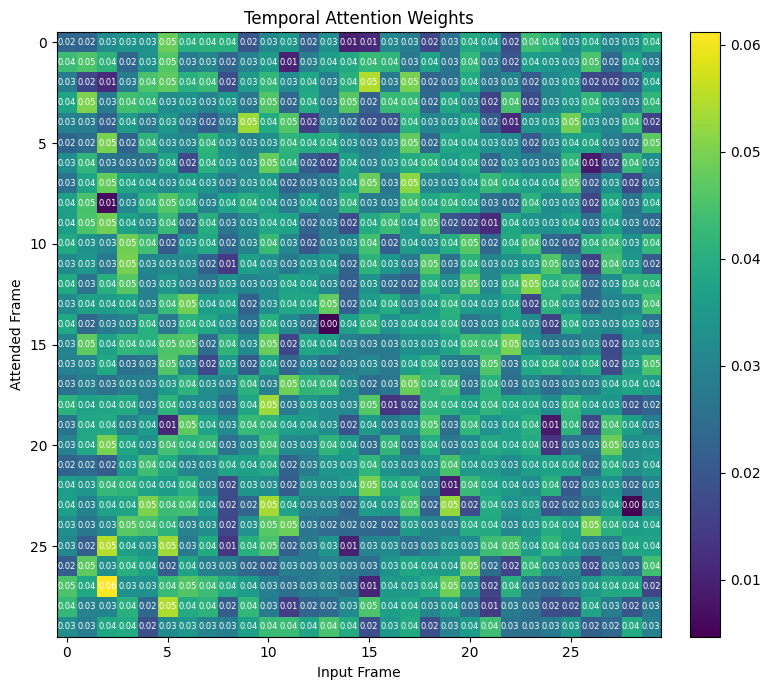

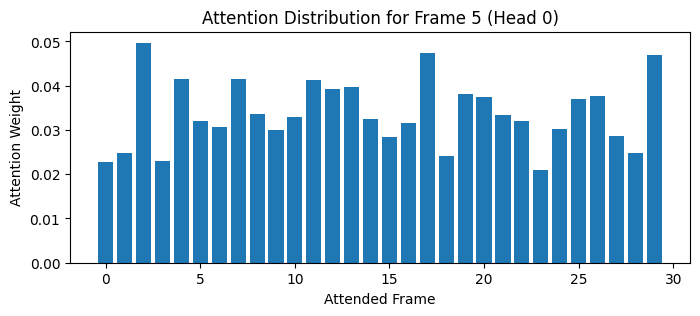

Valid top indices: [np.int64(2), np.int64(4), np.int64(7)]


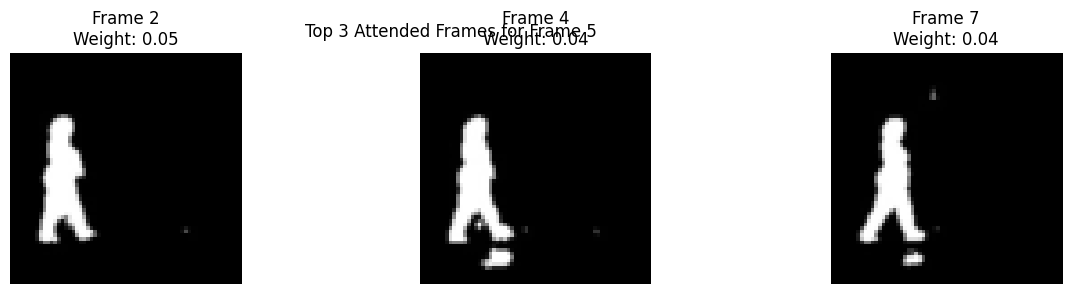

In [29]:
import matplotlib.pyplot as plt
import numpy as np
model = CSTL(num_classes=125).to(device)
test_folder = '/content/drive/MyDrive/silhouette/test'
image_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.jpg') or f.endswith('.png')])[:30]
images = []
for img_file in image_files:
    img_path = os.path.join(test_folder, img_file)
    images.append(transform(Image.open(img_path).convert('L')))
sequence = torch.stack(images).unsqueeze(0).to(device)  # [1, 16, 1, 64, 64]

# --- Get prediction and attention weights ---
with torch.no_grad():
    output, attn_weights = model(sequence, return_attention=True)

# --- Visualize attention weights for the first head ---
# attn_weights shape: [1, num_heads, seq_len, seq_len]
print("attn_weights shape:", attn_weights.shape)
attn = attn_weights[0].cpu().detach().numpy()  # shape: (30, 30)

plt.figure(figsize=(8, 7))
im = plt.imshow(attn, cmap='viridis')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Temporal Attention Weights')
plt.xlabel('Input Frame')
plt.ylabel('Attended Frame')

# Optionally annotate values
for i in range(attn.shape[0]):
    for j in range(attn.shape[1]):
        plt.text(j, i, f"{attn[i, j]:.2f}", ha="center", va="center", color="w", fontsize=6)

plt.tight_layout()
plt.show()

frame_idx = 5  # Choose a frame index
plt.figure(figsize=(8, 3))
plt.bar(np.arange(attn.shape[1]), attn[frame_idx])
plt.title(f'Attention Distribution for Frame {frame_idx} (Head 0)')
plt.xlabel('Attended Frame')
plt.ylabel('Attention Weight')
plt.show()

frame_idx = 5  # The frame in your sequence you are interested in
top_n = 5      # Number of most attended frames to display

# Get attention weights for this frame
weights = attn[frame_idx]  # shape: (seq_len,)

# Get indices of the top-N attended frames
top_indices = np.argsort(weights)[::-1][:top_n]

valid_top_indices = [idx for idx in top_indices if idx < len(images)]
print(f"Valid top indices: {valid_top_indices}")

plt.figure(figsize=(15, 3))
for i, idx in enumerate(valid_top_indices):
    img = images[idx].squeeze().cpu().numpy()
    plt.subplot(1, len(valid_top_indices), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Frame {idx}\nWeight: {weights[idx]:.2f}")
    plt.axis('off')

plt.suptitle(f"Top {len(valid_top_indices)} Attended Frames for Frame {frame_idx}                         ")
plt.show()

